# Three block, two fold JIVE analysis of cartilage data at enrollment 

In [15]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import dask
import dask.distributed
import jive.AJIVE
import jive.PCA
import os

In [2]:
cluster = dask.distributed.LocalCluster(processes=True)
client = dask.distributed.Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50565,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50582,Total threads: 1
Dashboard: http://127.0.0.1:50585/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50570,


In [3]:
AJIVE_INPUT_DIR = 'processed_data/ajive_input_fold1/'
AJIVE_OUTPUT_DIR = 'processed_data/ajive_output_fold1/'

In [4]:
clin_ds = (xarray.open_zarr(AJIVE_INPUT_DIR + 'clinical.zarr/')
           .set_index({'knee':['patient_id','side']})
          )
clin_ds

<xarray.Dataset>
Dimensions:       (knee: 3127)
Coordinates:
    timepoint     int64 ...
  * knee          (knee) MultiIndex
  - patient_id    (knee) int64 9083898 9083898 9017909 ... 9478285 9478285
  - side          (knee) object 'left' 'right' 'left' ... 'right' 'left' 'right'
Data variables: (12/77)
    Asian race    (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    Black race    (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    BothHP12      (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    BothHRS       (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    Female Sex    (knee) int64 dask.array<chunksize=(3127,), meta=np.ndarray>
    Is Married    (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    ...            ...
    V00eSFP       (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    V00eSFR       (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    V00fSFP       (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    V00fSFR       (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    V00fmaxf      (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>
    White race    (knee) float64 dask.array<chunksize=(3127,), meta=np.ndarray>

In [5]:
clin_df = clin_ds.to_pandas()
clin_df.head()

Asian race  Black race  BothHP12  BothHRS  Female Sex  \
patient_id side                                                           
9083898    left          0.0         1.0       1.0      0.0           1   
           right         0.0         1.0       1.0      0.0           1   
9017909    left          0.0         1.0       0.0      0.0           1   
           right         0.0         1.0       0.0      0.0           1   
9309170    left          0.0         1.0       0.0      0.0           1   

                  Is Married  LowIncome  MaxDrinksWk  OppositeHP12  \
patient_id side                                                      
9083898    left          0.0        1.0    -1.572337           1.0   
           right         0.0        1.0    -1.572337           1.0   
9017909    left          0.0        1.0    -0.415064           0.0   
           right         0.0        1.0    -0.415064           0.0   
9309170    left          1.0        0.0    -0.415064           0.0   

                  OppositeHRS  ...  V00WOMADL  V00WOMKP  V00WOMSTF   V00eSFP  \
patient_id side                ...                                             
9083898    left           0.0  ...   1.807402  2.525453        5.0 -1.751447   
           right          0.0  ...   1.236466  1.446453        2.0 -2.349752   
9017909    left           0.0  ...   1.236466  0.730657        2.0 -0.670187   
           right          0.0  ...   1.615335  1.014101        4.0 -1.146054   
9309170    left           0.0  ...   1.446389  0.730657        3.0 -1.211307   

                   V00eSFR   V00fSFP   V00fSFR  V00fmaxf  White race  \
patient_id side                                                        
9083898    left   0.688994 -1.321835 -2.240006 -1.809600         0.0   
           right  0.519347 -2.051840 -2.149248 -2.375887         0.0   
9017909    left  -1.677836 -1.070063 -0.883897 -1.330596         0.0   
           right -0.601173 -1.612849 -2.351969 -2.156883         0.0   
9309170    left   0.536955 -0.867823 -1.247481 -0.856439         0.0   

                  timepoint  
patient_id side              
9083898    left           0  
           right          0  
9017909    left           0  
           right          0  
9309170    left           0  

[5 rows x 78 columns]

In [6]:
fem_ds = xarray.open_zarr(AJIVE_INPUT_DIR + 'femoral.zarr/')
fem_ds

<xarray.Dataset>
Dimensions:     (knee: 3127, xy: 57260)
Coordinates:
    patient_id  (knee) int64 dask.array<chunksize=(3127,), meta=np.ndarray>
    side        (knee) <U5 dask.array<chunksize=(3127,), meta=np.ndarray>
    timepoint   int64 ...
    x           (xy) int64 dask.array<chunksize=(28630,), meta=np.ndarray>
    y           (xy) int64 dask.array<chunksize=(28630,), meta=np.ndarray>
Dimensions without coordinates: knee, xy
Data variables:
    femoral     (knee, xy) float32 dask.array<chunksize=(348, 57260), meta=np.ndarray>

In [7]:
fem_ds = fem_ds.set_index(knee=['patient_id', 'side'], xy=['x','y'])
fem_ds

<xarray.Dataset>
Dimensions:     (knee: 3127, xy: 57260)
Coordinates:
    timepoint   int64 ...
  * knee        (knee) MultiIndex
  - patient_id  (knee) int64 9083898 9083898 9017909 ... 9837054 9478285 9478285
  - side        (knee) object 'left' 'right' 'left' ... 'right' 'left' 'right'
  * xy          (xy) MultiIndex
  - x           (xy) int64 5 5 5 5 5 5 5 5 5 ... 305 305 305 305 305 305 305 305
  - y           (xy) int64 108 109 110 111 112 113 114 ... 84 85 86 87 88 89 90
Data variables:
    femoral     (knee, xy) float32 dask.array<chunksize=(348, 57260), meta=np.ndarray>

In [8]:
fem_df = fem_ds['femoral'].to_pandas()
fem_df.head()

x                      5                                                      \
y                      108       109       110       111       112       113   
patient_id side                                                                
9083898    left   0.809047  0.799487  0.827793  0.828075  0.828356  0.731081   
           right  1.100899  1.118018  1.109131  1.136588  1.164046  1.156132   
9017909    left   1.194910  1.215796  1.150897  1.095565  1.040233  0.937497   
           right  1.293012  1.303417  1.230636  1.168165  1.105695  1.049284   
9309170    left   2.007337  2.028169  2.030721  1.848034  1.665346  1.579102   

x                                                         ...       305  \
y                      114       115       116       117  ...       81    
patient_id side                                           ...             
9083898    left   0.538654  0.407462  0.337426  0.408192  ...  1.881041   
           right  1.233964  1.244246  1.214963  1.227599  ...  0.540772   
9017909    left   0.908312  0.819502  0.715750  0.778630  ...  1.411718   
           right  0.972333  0.869180  0.795963  0.881610  ...  1.459111   
9309170    left   1.446370  1.471499  1.577059  1.582643  ...  0.631070   

x                                                                             \
y                      82        83        84        85        86        87    
patient_id side                                                                
9083898    left   1.923470  1.892218  1.831712  1.849051  1.716530  1.744408   
           right  0.431159  0.592475  0.639594  0.755071  0.796785  0.589294   
9017909    left   1.454134  1.421857  1.280921  1.253374  1.222574  1.175984   
           right  1.438980  1.365844  1.305614  1.288732  1.262824  1.246679   
9309170    left   0.632149  0.546614  0.398508  0.535442  0.473053  0.580378   

x                                               
y                      88        89        90   
patient_id side                                 
9083898    left   1.661299  1.565672  1.392427  
           right  0.494577  0.654446  0.754237  
9017909    left   1.165744  1.181314  1.183533  
           right  1.226616  1.235501  1.194169  
9309170    left   0.505694  0.335415  0.236284  

[5 rows x 57260 columns]

In [9]:
tib_ds = xarray.open_zarr(AJIVE_INPUT_DIR + 'tibial.zarr/')
tib_ds = tib_ds.set_index(knee=['patient_id', 'side'], xy=['x','y'])

In [10]:
tib_df = tib_ds['tibial'].to_pandas()
tib_df.head()

x                      6                                                      \
y                      89        90        91        92        93        94    
patient_id side                                                                
9083898    left   0.155599  0.161127  0.166654  0.172182  0.177709  0.183237   
           right  0.424967  0.436445  0.447922  0.459400  0.470877  0.482355   
9017909    left   1.241411  1.245888  1.250365  1.254842  1.259319  1.263796   
           right  1.361542  1.394871  1.428200  1.461529  1.494858  1.528187   
9309170    left   0.322829  0.333171  0.343513  0.353855  0.364197  0.374539   

x                                                         ...       304  \
y                      95        96        97        98   ...       181   
patient_id side                                           ...             
9083898    left   0.188765  0.194292  0.199820  0.205347  ...  0.628956   
           right  0.493833  0.505310  0.516788  0.528266  ...  0.811433   
9017909    left   1.268273  1.272751  1.277228  1.281705  ...  0.759574   
           right  1.561516  1.594845  1.628174  1.661503  ...  0.658796   
9309170    left   0.384881  0.395223  0.405565  0.415907  ...  0.368994   

x                                                                             \
y                      182       183       184       185       186       187   
patient_id side                                                                
9083898    left   0.632595  0.642301  0.641579  0.653414  0.695248  0.706194   
           right  0.824384  0.813005  0.821264  0.822181  0.854738  0.860121   
9017909    left   0.717754  0.632826  0.593152  0.603281  0.611680  0.603063   
           right  0.693805  0.811468  0.809643  0.806671  0.804248  0.809177   
9309170    left   0.367519  0.365997  0.365218  0.365059  0.364888  0.364769   

x                                               
y                      188       189       190  
patient_id side                                 
9083898    left   0.682057  0.593053  0.462839  
           right  0.876452  0.886862  0.904521  
9017909    left   0.588375  0.575691  0.621390  
           right  0.793121  0.698680  0.499119  
9309170    left   0.364668  0.364610  0.364585  

[5 rows x 56340 columns]

# Compute JIVE

In [11]:
pca_femoral = jive.PCA.PCA()
pca_femoral.fit(fem_df)

Rank 3127 PCA of a (3127, 57260) matrix

In [12]:
pca_tibial = jive.PCA.PCA()
pca_tibial.fit(tib_df)

Rank 3127 PCA of a (3127, 56340) matrix

In [13]:
pca_clinical = jive.PCA.PCA()
pca_clinical.fit(clin_df)

Rank 78 PCA of a (3127, 78) matrix

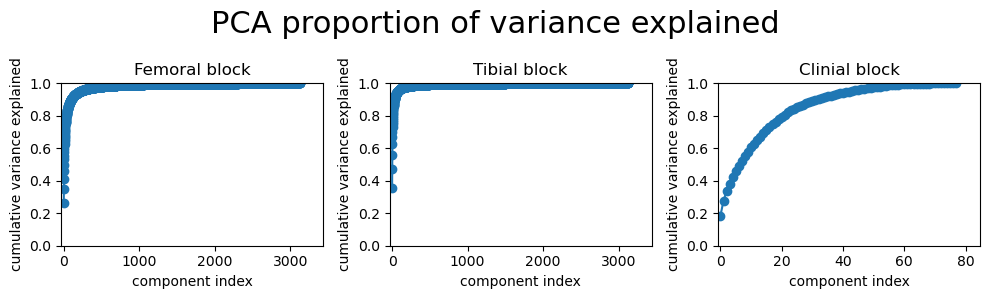

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(131)
pca_femoral.plot_var_expl_cum()
plt.title("Femoral block")
plt.subplot(132)
pca_tibial.plot_var_expl_cum()
plt.title("Tibial block")
plt.subplot(133)
pca_clinical.plot_var_expl_cum()
plt.title("Clinial block")
plt.suptitle("PCA proportion of variance explained", fontsize=22)
plt.tight_layout()

In [17]:
ajive = jive.AJIVE.AJIVE(init_signal_ranks={'clinical': 60, 'femoral': 60, 'tibial': 60}, store_full=False)

In [18]:
%%time
ajive.fit(blocks={'femoral': fem_df, 'tibial': tib_df, 'clinical': clin_df},
          precomp_init_svd={'femoral': pca_femoral.get_UDV(),
                            'tibial':  pca_tibial.get_UDV(),
                            'clinical': pca_clinical.get_UDV()})

CPU times: user 2h 31min 9s, sys: 32min 20s, total: 3h 3min 30s
Wall time: 1h 50min 43s


AJIVE, joint rank: 5, block femoral indiv rank: 57, block tibial indiv rank: 58, block clinical indiv rank: 59

In [19]:
if not os.path.exists(AJIVE_OUTPUT_DIR):
    os.makedirs(AJIVE_OUTPUT_DIR)
    
ajive.save(AJIVE_OUTPUT_DIR + "ajive_fit")